In [1]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter


In [2]:
# Problem parameters
N = 5  # Number of PEVGs
C = 99  # Grid capacity (MWh)
b_n = np.random.uniform(35, 65, N)  # Battery capacities
s_n = np.random.uniform(1, 2, N)    # Satisfaction parameters

In [3]:
# Define the multi-objective problem
class EVChargingProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=N + 1,  # p + x_1, x_2, ..., x_N
            n_obj=2,       # Two objectives: SG revenue and PEVG utility
            n_constr=0,    # One constraint: sum(x_n) <= C
            xl=np.array([0] + [0] * N),  # Lower bounds: p >= 0, x_n >= 0
            xu=np.array([50] + [C] * N)  # Upper bounds: p <= 50, x_n <= C
        )

    def _evaluate(self, X, out, *args, **kwargs):
        p = X[0]  # Price
        x = X[1:]  # Demands

        # Objective 1: SG revenue (maximize)
        f1 = p * np.sum(x)

        # Objective 2: PEVG total utility (maximize)
        f2 = np.sum(b_n * x - 0.5 * s_n * x**2 - p * x)

        # Constraint: sum(x_n) <= C (g(x) <= 0)
        g1 = np.sum(x) - C

        # MOEA/D minimizes, so negate objectives to maximize
        out["F"] = [-f1, -f2]
        out["G"] = []

In [4]:
# Initialize MOEA/D algorithm
algorithm = MOEAD(
    ref_dirs=np.array([[1.0, 0.0], [0.75, 0.25], [0.5, 0.5], [0.25, 0.75], [0.0, 1.0]]),  # Weight vectors
    n_neighbors=5,  # Neighborhood size
    prob_neighbor=0.9,  # Probability of using neighbors
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20)
)

In [5]:
# Define the problem
problem = EVChargingProblem()

In [11]:
# Run optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', 200),  # Number of generations
    seed=1,
    verbose=False
)

In [12]:
# Extract results
X = res.X  # Decision variables (p, x_1, ..., x_N)
F = res.F  # Objective values (negated: -f1, -f2)
F = -F  # Convert back to maximized form

In [13]:
# Print solutions
print("Pareto-optimal solutions:")
for i in range(len(X)):
    p = X[i][0]
    x = X[i][1:]
    sg_revenue = F[i][0]
    pevg_utility = F[i][1]
    total_demand = np.sum(x)
    print(f"Solution {i+1}:")
    print(f"  Price (p) = {p:.2f} USD/MWh")
    print(f"  Demands (x_n) = {x}")
    print(f"  SG Revenue = {sg_revenue:.2f}")
    print(f"  PEVG Total Utility = {pevg_utility:.2f}")
    print(f"  Total Demand = {total_demand:.2f} MWh (Constraint: <= {C})")
    print()

Pareto-optimal solutions:
Solution 1:
  Price (p) = 49.71 USD/MWh
  Demands (x_n) = [44.66406489 75.56193334 61.43371673 63.11199359 96.29881726]
  SG Revenue = 16954.09
  PEVG Total Utility = -19956.21
  Total Demand = 341.07 MWh (Constraint: <= 99)

Solution 2:
  Price (p) = 49.58 USD/MWh
  Demands (x_n) = [50.47292366 41.1866512  38.26072487 59.50135702 54.69900981]
  SG Revenue = 12103.58
  PEVG Total Utility = -10616.57
  Total Demand = 244.12 MWh (Constraint: <= 99)

Solution 3:
  Price (p) = 43.22 USD/MWh
  Demands (x_n) = [50.47292366 41.34040821 20.05147623 24.87358698 50.23930724]
  SG Revenue = 8080.50
  PEVG Total Utility = -5571.42
  Total Demand = 186.98 MWh (Constraint: <= 99)

Solution 4:
  Price (p) = 17.69 USD/MWh
  Demands (x_n) = [28.22802007 41.19466927 37.74670696 39.08813552 54.62499833]
  SG Revenue = 3553.18
  PEVG Total Utility = -745.77
  Total Demand = 200.88 MWh (Constraint: <= 99)

Solution 5:
  Price (p) = 0.07 USD/MWh
  Demands (x_n) = [25.82796001 23.16

In [14]:
# Post-process to approximate GSE
# GSE: p* = min(b_n - s_n x_n^*)
for i in range(len(X)):
    x = X[i][1:]
    p_star = np.min(b_n - s_n * x)
    sg_revenue_star = p_star * np.sum(x)
    pevg_utility_star = np.sum(b_n * x - 0.5 * s_n * x**2 - p_star * x)
    if sg_revenue_star >= 0 and pevg_utility_star >= 0:  # Ensure feasible
        print(f"GSE Approximation for Solution {i+1}:")
        print(f"  Adjusted Price (p*) = {p_star:.2f} USD/MWh")
        print(f"  SG Revenue = {sg_revenue_star:.2f}")
        print(f"  PEVG Total Utility = {pevg_utility_star:.2f}")
        print()


In [17]:
import matplotlib.pyplot as plt

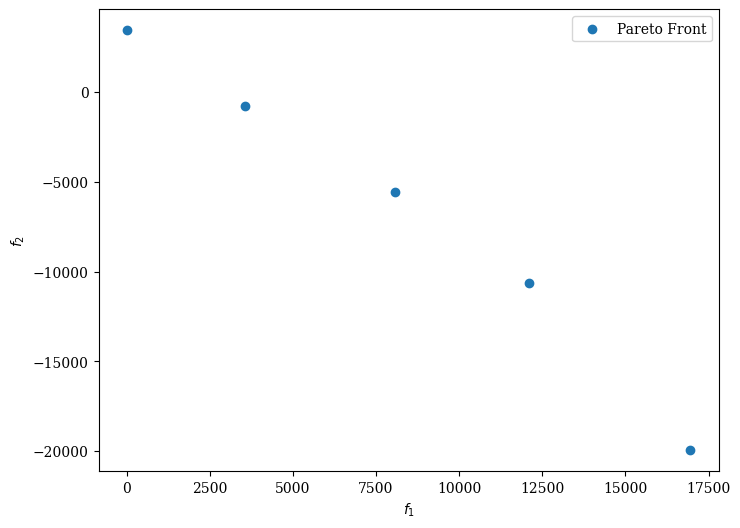

In [19]:

# Visualize Pareto front
plot = Scatter()
plot.add(F, label="Pareto Front")
plot.show()
plt.legend()
plt.show()